In [19]:
import sys
import subprocess
import pkg_resources

required = {'rasterstats','odc-ui'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
else:
    print(f'Required packages {required} already installed.')

import geopandas as gpd
import stackstac
import xarray as xr
import numpy as np

Required packages {'odc-ui', 'rasterstats'} already installed.


In [2]:
sys.path.append('/home/jovyan/PlanetaryComputerExamples/CODE/pcgrits/')
#from grits import humanbytes, get_field, get_lims, get_mms, xr_rasterize, calculate_indices, zscore_dataset
from grits import *

In [3]:
#%% PROVISIONAL REGION OF INTEREST PICKER
path = '/home/jovyan/PlanetaryComputerExamples/vetorial/FAZENDAS/'
savenc = '/home/jovyan/PlanetaryComputerExamples/myout_nc/'

### What do I want?

In [57]:
name = 'Uniguiri_'
datetime = '1985-01-01/2013-05-05'
lst = True
indices = ['EVI', 'LAI', 'BSI']
extract = True
visualize = False

### Define analysis area

got bbox, lat_range, lon_range
    PID  area_ha    R   ID      SR     Re   Fi     TID  \
0  R8_4      6.4  R8_    4  100000  80000    4  180004   
1     F     10.6    F  NaN  100000  80000  901  180901   
2  R8_5      6.9  R8_    5  100000  80000    5  180005   
3     C      0.7    C  NaN  100000  80000  801  180801   
4  R8_1      6.7  R8_    1  100000  80000    1  180001   

                                            geometry  
0  MULTIPOLYGON (((-54.57526 -16.95986, -54.57705...  
1  MULTIPOLYGON (((-54.57224 -16.96252, -54.57131...  
2  MULTIPOLYGON (((-54.57705 -16.96167, -54.57526...  
3  MULTIPOLYGON (((-54.56787 -16.95268, -54.56744...  
4  MULTIPOLYGON (((-54.57109 -16.95544, -54.57249...  


<Axes: >

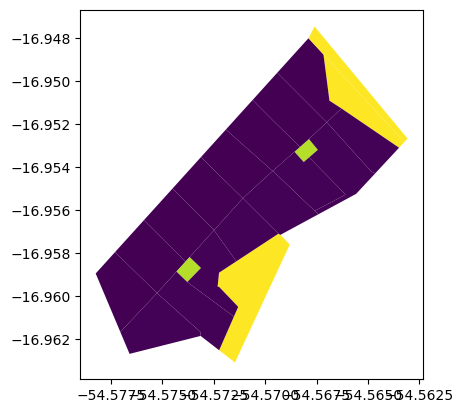

In [8]:
file = path + 'fazenda_uniguiri.gpkg'
layer = 'piquetes_tid'

# Get FIELD
field = gpd.read_file(file, layer=layer)
field = field[field['Re'] == 80000]

bbox, lat_range, lon_range = get_lims(field)
print(field.head())
field.plot(column='TID')

In [5]:
items = query_L457_items(datetime=datetime,
                         bbox=bbox,
                         max_cloud=30,
                         landsats = ["landsat-4", "landsat-5", "landsat-7"]
                        )



 found 379 items 
 first: <Item id=LT05_L2SP_225072_19850610_02_T1> 
 last: <Item id=LE07_L2SP_225072_20130311_02_T1> 

dict_keys(['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'lwir', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'swir16', 'swir22', 'mtl.txt', 'mtl.xml', 'cloud_qa', 'mtl.json', 'qa_pixel', 'qa_radsat', 'atmos_opacity', 'tilejson', 'rendered_preview'])


### Land Surface Temperature and zscores

In [68]:
assets = ['lwir','qa']

datat = (
        stackstac.stack(
        items,
        assets=assets,
        bounds_latlon=bbox,
        epsg=4326, # o xarray de imagens será retornado no EPSG:4326
        resolution = 0.000281612818071153, # cuidado se for mexer na resolucao, tente algo como 0.001 para começar, pois é graus (não metros)
    ))
datat = datat.rename({'x': 'longitude','y': 'latitude'})

# to dataset
if visualize:
    dst_ = datat.to_dataset(dim='band')
dst = datat.to_dataset(dim='band') 

dst

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.Dataset>
Dimensions:                      (time: 379, latitude: 57, longitude: 54,
                                  band: 2)
Coordinates: (12/26)
  * time                         (time) datetime64[ns] 1985-06-10T13:09:56.92...
    id                           (time) <U31 'LT05_L2SP_225072_19850610_02_T1...
  * longitude                    (longitude) float64 -54.58 -54.58 ... -54.56
  * latitude                     (latitude) float64 -16.95 -16.95 ... -16.96
    view:sun_elevation           (time) float64 35.92 35.12 35.62 ... 59.6 54.88
    gsd                          int64 30
    ...                           ...
    landsat:collection_category  <U2 'T1'
    proj:epsg                    int64 32621
    landsat:scene_id             (time) <U21 'LT52250721985161CUB04' ... 'LE7...
    raster:bands                 (band) object {'unit': 'kelvin', 'scale': 0....
    title                        (band) <U43 'Surface Temperature Band' 'Surf...
    epsg                         int64 4326
Dimensions without coordinates: band
Data variables:
    lwir                         (time, latitude, longitude) float64 dask.array<chunksize=(1, 57, 54), meta=np.ndarray>
    qa                           (time, latitude, longitude) float64 dask.array<chunksize=(1, 57, 54), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-54.57825381909788, -16.963229...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-54.58|\n| 0.00,-0.00,-16.95|\n| 0.00, 0.00, 1.00|
    resolution:  0.000281612818071153

In [49]:
np.unique(dst['qa'].astype("uint16").isel(time=3).values)

array([189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       216, 217, 218, 219, 220, 221, 222, 223, 224], dtype=uint16)

não tô sabendo decodificar os bits, tampouco validar essa bitmask

In [36]:
def apply_bitmask(arr) -> xr.DataArray or np.array:
    """Apply QA pixel bit mask for each array depending on platform"""

    unique_platform = np.unique(arr.platform.to_numpy())

    if ["landsat-8", "landsat-9"] in unique_platform:
        mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
    elif ["landsat-4", "landsat-5", "landsat-7"] in unique_platform:
        mask_bitfields = [1, 3, 4, 5]  # dilated cloud, cirrus, cloud, cloud shadow
    elif ["landsat-4", "landsat-5"] in unique_platform:
        mask_bitfields = [1, 3, 4, 5]  # dilated cloud, cirrus, cloud, cloud shadow
    else:
        raise ValueError(f"No bit mask defined for {arr.platform.to_numpy()}")

    print(unique_platform)
    bitmask = 0
    for field in mask_bitfields:
        bitmask |= 1 << field

    qa = arr.sel(band="qa").astype("uint16")
    bad = qa & bitmask  # just look at those 4 bits

    arr = arr.where(bad == 0)

    return arr


In [69]:
print('Land Surface Temperature requested. \n -> Converting to Celcius')

# get lwir11 band info
band_info = items[0].assets["lwir"].extra_fields["raster:bands"][0]
print(band_info)

dst['lwir'] = dst['lwir'].astype(float)
dst['lwir'] *=band_info['scale']
dst['lwir'] +=band_info['offset']
dst['lwir'] -= 273.15

drops = ['landsat:correction','landsat:wrs_path','landsat:wrs_row',
        'landsat:collection_number','landsat:wrs_type','instruments']


#dst = dst.drop_vars(drops)
dst = dst.rolling(time=4).mean(skipna=True)


Land Surface Temperature requested. 
 -> Converting to Celcius
{'unit': 'kelvin', 'scale': 0.00341802, 'nodata': 0, 'offset': 149.0, 'data_type': 'uint16', 'spatial_resolution': 30}


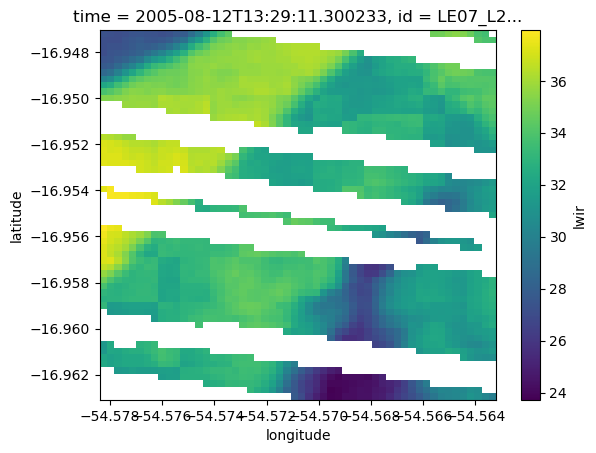

In [70]:
dst['lwir'].isel(time=240).plot()

In [72]:
dst['lwir']

<xarray.DataArray 'lwir' (time: 379, latitude: 57, longitude: 54)>
dask.array<truediv, shape=(379, 57, 54), dtype=float64, chunksize=(4, 57, 54), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                         (time) datetime64[ns] 1985-06-10T13:09:56.92...
    id                           (time) <U31 'LT05_L2SP_225072_19850610_02_T1...
  * longitude                    (longitude) float64 -54.58 -54.58 ... -54.56
  * latitude                     (latitude) float64 -16.95 -16.95 ... -16.96
    view:sun_elevation           (time) float64 35.92 35.12 35.62 ... 59.6 54.88
    gsd                          int64 30
    ...                           ...
    landsat:wrs_type             <U1 '2'
    landsat:correction           <U4 'L2SP'
    landsat:collection_category  <U2 'T1'
    proj:epsg                    int64 32621
    landsat:scene_id             (time) <U21 'LT52250721985161CUB04' ... 'LE7...
    epsg                         int64 4326

In [73]:

# exploring LST
#zlst = zscore_dataset(lst)
def calculate_zscore(da):
        '''
            zscore calculation
        '''
        mean = da.mean(skipna=True)
        std = da.std(skipna=True)
        zscore = (da - mean) / std
        return zscore

    # firstly turn the dataset into monthly data
grouped_ds = dst.groupby('time.month').mean()


In [75]:
zlst = calculate_zscore(dst['lwir'])
zlst

<xarray.DataArray 'lwir' (time: 379, latitude: 57, longitude: 54)>
dask.array<truediv, shape=(379, 57, 54), dtype=float64, chunksize=(4, 57, 54), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                         (time) datetime64[ns] 1985-06-10T13:09:56.92...
    id                           (time) <U31 'LT05_L2SP_225072_19850610_02_T1...
  * longitude                    (longitude) float64 -54.58 -54.58 ... -54.56
  * latitude                     (latitude) float64 -16.95 -16.95 ... -16.96
    view:sun_elevation           (time) float64 35.92 35.12 35.62 ... 59.6 54.88
    gsd                          int64 30
    ...                           ...
    landsat:wrs_type             <U1 '2'
    landsat:correction           <U4 'L2SP'
    landsat:collection_category  <U2 'T1'
    proj:epsg                    int64 32621
    landsat:scene_id             (time) <U21 'LT52250721985161CUB04' ... 'LE7...
    epsg                         int64 4326

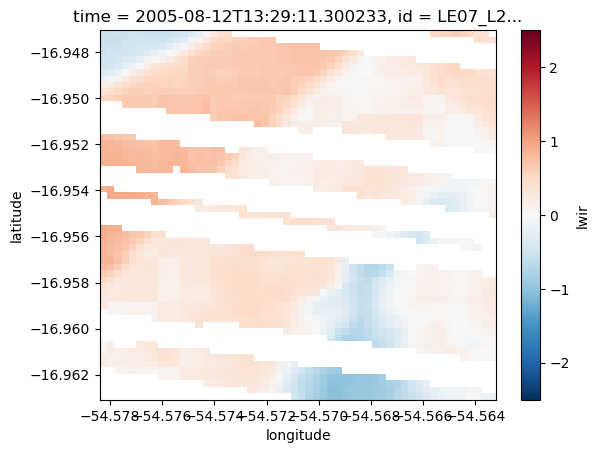

In [79]:
zlst.isel(time=240).plot(vmin = -2.5, vmax = 2.5, cmap='RdBu_r')

In [ ]:

# then, calculate zscore using the predefined function
zscore = grouped_ds.apply(calculate_zscore)



zlst = xr.where(zlst > 3.5, np.nan, zlst)
zlst = xr.where(zlst < -3.5, np.nan,zlst)
zlst.resample(time='M').mean(skipna=True)

print('Reprojecting and saving ... \n')
zlst = zlst.rio.write_crs('4326')
zlst = zlst.rio.reproject('EPSG:4326')
print('... saving ...')

zlst.to_netcdf(f'{savenc}zlst_{name}_57.nc', mode='w')
print(f'zlst_{name}.nc saved!')

In [ ]:
assets = ['blue','green','red','nir08','swir16','qa']

data = (
            stackstac.stack(
            items,
            assets=assets,
            bounds_latlon=bbox,
            epsg=4326, # o xarray de imagens será retornado no EPSG:4326
        )
    )

data = data.rename({'x': 'longitude','y': 'latitude'})
data